# Starting with DReAMy: encoding, reduction and visualisation

In this notebook, we will start using DReAMy and its basic funcionality. That is, downloading data, collecting embeddings for (some) dream reports, reducing the embeddings sapce and searching for significant patterns in the reduced space. 

In [1]:
! pip install dreamy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Let's start by getting some dreams. You can stard by dowloading a collection of dream-reports scraped from the DreamBank database, freely availabe from DReAMy's hugging face!

In [2]:
import dreamy

In [3]:
dream_bank = dreamy.get_HF_DreamBank(as_dataframe=True)

  0%|          | 0/1 [00:00<?, ?it/s]

As you can see, the file, dowloaded directlty as a pandas DataFrame, as three entires:
- dreams, the dream-reports
- series, the different collection of DreamBank
- description, a brief description of each series

In [4]:
dream_bank.sample(5)

,dreams,series,description
14715,"Simon's Quest I'm in Mexico, in a place that ...",kenneth,Kenneth
24157,"(02/23/97)[""The baby elephant types.""] I am in...",b2,Barb Sanders #2
28775,"My friend, Bull (who has cancer) and his son, ...",arlie,Arlie: a middle-aged woman
13710,I was walking around a sort of showcase room w...,madeline3-offcampus,Madeline 3: Off-Campus
5972,"(2000-02-12, 01.45 - Heidelberg)[Im Hotel Back...",vonuslar.de,"Detlev von Uslar, auf Deutsch"


Lets now sample a small set of dreams. If you have a more powerfull machine (or you are working on Colab), you can increase the number of report. Note than the whole dataset contains ~ 29 k reports.

In [5]:
n_samples = 10
dream_sample = dream_bank.sample(n_samples).reset_index(drop=True)

Now we get the reports as a list, and use the `.get_encodings` functions of dreamy to extract the encodings. The encodings are the the `[CLS]` token of an LLM. By default, the selected model is [`bert-base-cased`](https://huggingface.co/bert-base-cased). You can select a diffrent model, but this might contrast with the sourcee code.

In [6]:
dream_list       = dream_sample["dreams"].tolist()
report_encodings = dreamy.get_encodings(dream_list)

Loading/Downloading model and tokenizer


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Now that we have our embeddings for each report, we can use the `reduce_space` space function of dreamy. Available method are (for now) limited to `pca` and `t-sne`

In [7]:
X, Y = dreamy.reduce_space(report_encodings, method="pca")

After collecting the cooordinates of the reduced space, we can update the `DataFrame` of our selected sample with them so to facilitate plotting the obtained results.

In [8]:
dream_sample["DR_X"], dream_sample["DR_Y"] = X, Y

To visualise the resuced spece, we will make use of `seabonr`, since it well integrates with pandas. We will plot the 2-D space as a scatter plot, and use the different series as hue.

In [9]:
import seaborn as sns

sns.set_context("talk")
sns.set_style("whitegrid")

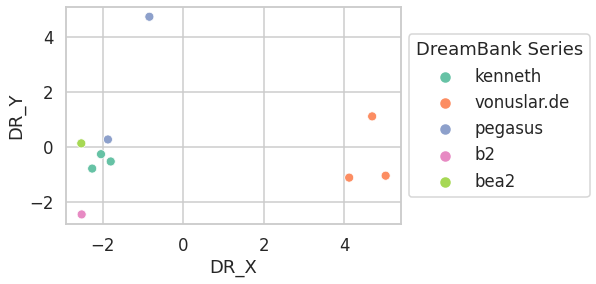

In [10]:
g = sns.scatterplot(
    data=dream_sample, 
    x="DR_X", 
    y="DR_Y", 
    hue="series",
    palette="Set2"
)
g.legend(loc='center left', title="DreamBank Series", bbox_to_anchor=(1, 0.5))

So, we got a small "problem". We forgot to remove the dream in German (`vonuslar.de`), and it looks like the (English-only) model defenetly saw something strange in those data 😅. 

Remember that transformers use non-linguistic sub-words tokens to deal with the out of vocabulary issue. Most likely, 99% of the `vonuslar.de` reports are built out of these sub-words, and are hence very easy to detect as the only meaningfully different cluster by PCA!.